In [0]:
#Importing libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
##Load the file from google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

path = "/content/drive/My Drive/IMDB_Dataset.csv"
IMDB_data = pd.read_csv(path)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#Checking the Structure of data
IMDB_data.head()
IMDB_data.shape
IMDB_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
#Encoding the sentiment to 0 and 1 where 0 corresponds to negative review and 1 is positive review
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
IMDB_data['sentiment'] = label_encoder.fit_transform(IMDB_data['sentiment'])
IMDB_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [0]:
#Defining the function for cleaning text
import re
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
    text = text.lower()
    return text

In [0]:
#Separating dependent and target variable 
X = IMDB_data.review.apply(cleanText)      #applying cleanText function
y = IMDB_data.sentiment

In [8]:
# split data into training and testing sets ; later we will split the training data further into train and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))

Train dataset shape: (40000,), 
Test dataset shape: (10000,)


In [0]:
#Spliting text into words using tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
max_features = 10000
max_len = 500
tok = Tokenizer(num_words=max_features)
#Creating sequences in training data
tok.fit_on_texts(X_train)
train_sequences = tok.texts_to_sequences(X_train)

In [10]:
#Padding sequences in training data
X_train = sequence.pad_sequences(train_sequences, maxlen=max_len)
X_train.shape

(40000, 500)

In [11]:
##Creating and padding sequences in the test data
test_sequences = tok.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(test_sequences, maxlen=max_len)
X_test.shape

(10000, 500)

In [12]:
##CNN Model
model1 = Sequential()
embedding_size = 128
model1.add(Embedding(max_features,
                    embedding_size,
                    input_length=max_len))

model1.add(Conv1D(250, 3, activation='relu'))
model1.add(GlobalMaxPooling1D())
model1.add(Dropout(0.2)),
model1.add(Dense(1, activation='sigmoid'))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 498, 250)          96250     
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 251       
Total params: 1,376,501
Trainable params: 1,376,501
Non-trainable params: 0
_________________________________________________________________


In [13]:
model1.compile(loss= 'binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
history = model1.fit(X_train, y_train, epochs=10,batch_size=100, validation_split=0.375,
                    callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.001)])

Epoch 1/10
250/250 [==============================] - 10s 42ms/step - loss: 0.4750 - accuracy: 0.7726 - val_loss: 0.3190 - val_accuracy: 0.8640
Epoch 2/10
250/250 [==============================] - 10s 40ms/step - loss: 0.2609 - accuracy: 0.8950 - val_loss: 0.2690 - val_accuracy: 0.8893
Epoch 3/10
250/250 [==============================] - 10s 40ms/step - loss: 0.1694 - accuracy: 0.9379 - val_loss: 0.2731 - val_accuracy: 0.8893


In [14]:
# Next, compare how the model performs on the test dataset:
test_loss, test_acc = model1.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 2s 5ms/step - loss: 0.2597 - accuracy: 0.8889
Test loss: 0.2596762776374817
Test accuracy: 0.8888999819755554


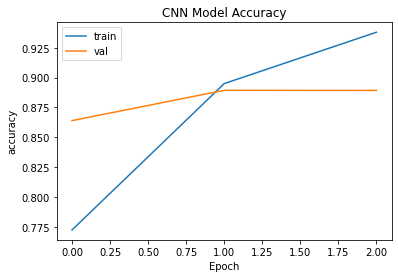

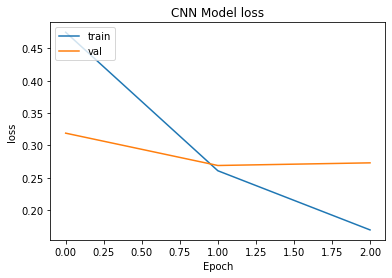

In [15]:
#Plotting the training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('CNN Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

#Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('CNN Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [16]:
#CNN model with two different kernel sizes
model2 = Sequential()
embedding_size = 128
model2.add(Embedding(max_features,
                    embedding_size,
                    input_length=max_len))

model2.add(Conv1D(250, 5, activation='relu'))
model2.add(Conv1D(250, 3, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dropout(0.2)),
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 496, 250)          160250    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 494, 250)          187750    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
Total params: 1,628,251
Trainable params: 1,628,251
Non-trainable params: 0
____________________________________________

In [17]:
model2.compile(loss= 'binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
history = model2.fit(X_train, y_train, epochs=10,batch_size=100, validation_split=0.375,
                    callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.001)])

Epoch 1/10
250/250 [==============================] - 14s 57ms/step - loss: 0.4466 - accuracy: 0.7716 - val_loss: 0.3065 - val_accuracy: 0.8702
Epoch 2/10
250/250 [==============================] - 14s 57ms/step - loss: 0.2239 - accuracy: 0.9118 - val_loss: 0.2686 - val_accuracy: 0.8872
Epoch 3/10
250/250 [==============================] - 14s 57ms/step - loss: 0.1094 - accuracy: 0.9612 - val_loss: 0.3282 - val_accuracy: 0.8789


In [18]:
# Next, compare how the model performs on the test dataset:
test_loss, test_acc = model2.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 2s 6ms/step - loss: 0.3261 - accuracy: 0.8789
Test loss: 0.32609111070632935
Test accuracy: 0.8788999915122986


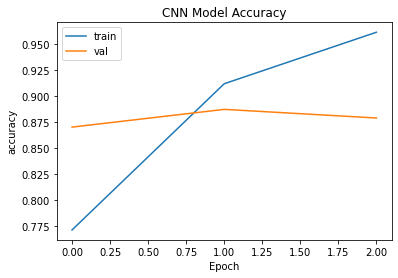

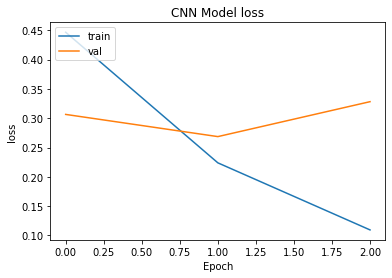

In [20]:
#Plotting the training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('CNN Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

#Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('CNN Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [37]:
## CNN with LSTM - best implementation

from tensorflow.keras import layers
model3 = Sequential()
embedding_size = 128
model3.add(Embedding(max_features,
                    embedding_size,
                    input_length=max_len))

model3.add(Conv1D(128, 5, activation='relu'))
model3.add(layers.LSTM(64))
model3.add(Dropout(0.5)),
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.5)),
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 496, 128)          82048     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [38]:
model3.compile(loss= 'binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
history = model3.fit(X_train, y_train, epochs=10,batch_size=100, validation_split=0.375,
                    callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.001)])

Epoch 1/10
250/250 [==============================] - 18s 71ms/step - loss: 0.4911 - accuracy: 0.7530 - val_loss: 0.3231 - val_accuracy: 0.8667
Epoch 2/10
250/250 [==============================] - 17s 70ms/step - loss: 0.2718 - accuracy: 0.8996 - val_loss: 0.3075 - val_accuracy: 0.8705
Epoch 3/10
250/250 [==============================] - 18s 70ms/step - loss: 0.1959 - accuracy: 0.9316 - val_loss: 0.2978 - val_accuracy: 0.8875
Epoch 4/10
250/250 [==============================] - 17s 70ms/step - loss: 0.1256 - accuracy: 0.9575 - val_loss: 0.4099 - val_accuracy: 0.8847


In [39]:
# Next, compare how the model performs on the test dataset:
test_loss, test_acc = model3.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 4s 12ms/step - loss: 0.3840 - accuracy: 0.8893
Test loss: 0.3839647173881531
Test accuracy: 0.8892999887466431


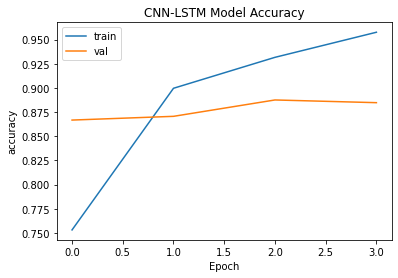

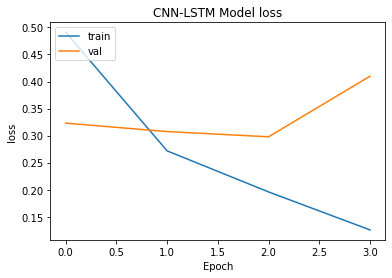

In [40]:
#Plotting the training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('CNN-LSTM Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

#Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('CNN-LSTM Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [0]:
#Saving the developed model
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
model.save('/content/gdrive/My Drive/Models/mymodel1.h5')